## Datasets merged so far:
* DTI data
* 2016VulnerableGroups.xlsx
* 2017HealthPersonnel_2017.xlsx
* 2019TypeHealthFacility_2019.xlsx
* 2021TypeHealthFacility_2021.xlsx
* NumberSchools_enrollment_SexDisaggregation_2017/18
* ToiletType_2010_PSA

## Blockers on other datasets
* 2015HousingCensus_2015_PSA.xlsx: need flattening. need cleanup.
* SmallArea_PovertyEstimates_2006_2009_2012_PSA.csv: none. merge to follow. 
* 2021 Full Year Official Poverty Statistics Tables_f(2).xlsx: includes mostly cities only. please confirm if proceed to merge.
* 3_2020 Deaths Statistical Tables_JRV_CRD: please flatten. region, district, province, and city/municipality are all in the same column. columns are multi-indexed as well. 


In [ ]:
import os
import re
from pathlib import Path

import geopandas as gp
import pandas as pd

import functools as ft

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [645]:
# Setting up directories

WORKINGDIR = Path(os.getcwd())
PROJECTROOT = WORKINGDIR.parents[1]

SHAPEFILE_V2 = Path("data", "geolocation", "ph_cities_joined_v2", "ph_cities_v2.shp")
MERGED_DATASET = Path("data", "merged-dataset", "merged-dataset.shp")

In [646]:
HEALTH_FACILITY_2019 = Path("data", "gathered-datasets", "health-facility-2019.csv")
HEALTH_FACILITY_2021 = Path("data", "gathered-datasets", "health-facility-2019.csv")
HEALTH_PERSONNEL = Path("data", "gathered-datasets", "health-personnel.csv")
SCHOOLS = Path("data", "gathered-datasets", "schools-sex-disaggregation.csv")
TOILET_TYPE = Path("data", "gathered-datasets", "toilet-type.csv")
VULNERABLE_GRPS = Path("data", "gathered-datasets", "vulnerable-grps.csv")

In [647]:
def data_cleaner(text):
    # Make lower caps
    text = text.lower()

    # Remove "city"
    text = text.replace("city", "")

    # Remove " of "
    text = text.replace(" of ", "")
    
    # Remove all strings within parentheses
    text = text.split(" (")[0]
    
    # Remove (Capital)
    text = text.replace(" (capital)", "")

    # Remove punctuation marks
    text = re.sub(r"[^\w\s]", "", text)

    # Remove spaces
    text = text.replace(" ", "")

    # Replace compostela valley with Davao de Oro
    text = text.replace("compostelavalley", "davaodeoro")

    # Replace Maguindanao with del Norte/del Sur
    if "maguindanao" in text:
        text = "maguindanao"

    # Replace santo with sto
    text = text.replace("santo", "sto")

    # Replace santa with sta
    text = text.replace("santa", "sta")



    return text

In [648]:
def remove_period(int_):
    int_ = str(int_)
    int_ = int_.replace(".", "")
    
    return int(int_)

In [649]:
def correct_province(province):
    if province == "Cotabato (North Cotabato)":
        return "Cotabato"
    elif province == "Samar (Western Samar)":
        return "Samar"
    else:
        return province

In [650]:
gdf = gp.read_file(Path(PROJECTROOT, SHAPEFILE_V2))
gdf.head()

,psgc,name,city_munic,province,clean_idx,longitude,latitude,coords,geometry
0,1705301000,Aborlan,Aborlan,Palawan,"aborlan, palawan",118.548417,9.437101,"9.4371009, 118.5484168","MULTIPOLYGON (((118.57998 9.37215, 118.57982 9..."
1,1705101000,Abra De Ilog,Abra De Ilog,Occidental Mindoro,"abradeilog, occidentalmindoro",120.726826,13.443721,"13.4437209, 120.7268262","POLYGON ((120.60896 13.35233, 120.60797 13.373..."
2,300801000,Abucay,Abucay,Bataan,"abucay, bataan",120.534870,14.721315,"14.7213146, 120.5348704","POLYGON ((120.45676 14.69671, 120.45620 14.696..."
3,201501000,Abulug,Abulug,Cagayan,"abulug, cagayan",121.457273,18.443485,"18.4434854, 121.4572732","MULTIPOLYGON (((121.40276 18.40896, 121.40276 ..."
4,803701000,Abuyog,Abuyog,Leyte,"abuyog, leyte",125.011485,10.747102,"10.747102, 125.0114853","POLYGON ((125.04650 10.56751, 125.04588 10.576..."


In [651]:
gdf.shape

(1634, 9)

## Merging DTI data

In [652]:
DTI_DATA = Path("data", "dti-competitive-index", "2-merged", "merged-dti-data.csv")

In [653]:
dti_data = pd.read_csv(Path(PROJECTROOT, DTI_DATA))

In [654]:
dti_data.shape

(1632, 211)

In [655]:
dti_data.head()

,city_municipality,2018 - Local Economy Size,2018 - Local Economy Growth,2018 - Active Establishments in the Locality,2018 - Safety Compliant Business,2018 - Employment Generation,2018 - Cost of Living,2018 - Cost of Doing Business,2018 - Financial Deepening,2018 - Productivity,...,2022 - Start Up and Innovation Facilities,2022 - Innovation Financing: R&D Expenditures Allotment,2022 - STEM graduates,2022 - Intellectual Property Registration,2022 - ICT Use: E-BPLS Software,2022 - Internet Capability,2022 - Availability of Basic Internet Service,2022 - Online Payment Facilities,2022 - ICT Plan,2022 - New Technology
0,Aborlan,0.0072,0.0224,0.2337,0.1253,0.0197,1.9907,2.1771,0.0423,0.0047,...,0.1281,0.0000,0.0195,0.0221,2.0,0.0095,0.0000,0.0,2.0001,0.0
1,Abra De Ilog,0.0027,0.0102,0.0477,0.0282,0.0008,2.3611,2.2200,0.0184,0.0579,...,0.0000,0.0000,0.0000,0.0009,2.0,0.0095,0.0000,0.0,0.0000,0.0
2,Abucay,0.0488,0.0020,0.0053,0.2363,0.2299,1.1111,1.8373,0.0965,0.0198,...,0.0533,0.0038,0.0047,0.0483,2.0,0.1957,0.1194,0.0,2.0001,0.0
3,Abulug,0.0651,0.0052,0.0053,0.2440,0.1548,1.2963,2.0402,0.1762,0.0103,...,0.0267,0.0000,0.0023,0.0000,0.0,0.1087,0.0000,0.0,0.6667,0.0
4,Abuyog,0.0115,0.0208,0.1813,0.3592,0.0499,1.0185,1.1430,0.1049,0.0028,...,0.0000,0.0000,0.0522,0.0000,2.0,1.0476,0.0037,0.0,1.3334,0.0


In [656]:
gdf = gdf.merge(dti_data,
                how="left",
                left_on="name",
                right_on="city_municipality")

In [657]:
gdf.drop(columns=["city_municipality"], inplace=True) # Drop duplicate column

In [658]:
gdf.head()

,psgc,name,city_munic,province,clean_idx,longitude,latitude,coords,geometry,2018 - Local Economy Size,...,2022 - Start Up and Innovation Facilities,2022 - Innovation Financing: R&D Expenditures Allotment,2022 - STEM graduates,2022 - Intellectual Property Registration,2022 - ICT Use: E-BPLS Software,2022 - Internet Capability,2022 - Availability of Basic Internet Service,2022 - Online Payment Facilities,2022 - ICT Plan,2022 - New Technology
0,1705301000,Aborlan,Aborlan,Palawan,"aborlan, palawan",118.548417,9.437101,"9.4371009, 118.5484168","MULTIPOLYGON (((118.57998 9.37215, 118.57982 9...",0.0072,...,0.1281,0.0000,0.0195,0.0221,2.0,0.0095,0.0000,0.0,2.0001,0.0
1,1705101000,Abra De Ilog,Abra De Ilog,Occidental Mindoro,"abradeilog, occidentalmindoro",120.726826,13.443721,"13.4437209, 120.7268262","POLYGON ((120.60896 13.35233, 120.60797 13.373...",0.0027,...,0.0000,0.0000,0.0000,0.0009,2.0,0.0095,0.0000,0.0,0.0000,0.0
2,300801000,Abucay,Abucay,Bataan,"abucay, bataan",120.534870,14.721315,"14.7213146, 120.5348704","POLYGON ((120.45676 14.69671, 120.45620 14.696...",0.0488,...,0.0533,0.0038,0.0047,0.0483,2.0,0.1957,0.1194,0.0,2.0001,0.0
3,201501000,Abulug,Abulug,Cagayan,"abulug, cagayan",121.457273,18.443485,"18.4434854, 121.4572732","MULTIPOLYGON (((121.40276 18.40896, 121.40276 ...",0.0651,...,0.0267,0.0000,0.0023,0.0000,0.0,0.1087,0.0000,0.0,0.6667,0.0
4,803701000,Abuyog,Abuyog,Leyte,"abuyog, leyte",125.011485,10.747102,"10.747102, 125.0114853","POLYGON ((125.04650 10.56751, 125.04588 10.576...",0.0115,...,0.0000,0.0000,0.0522,0.0000,2.0,1.0476,0.0037,0.0,1.3334,0.0


## Merging gathered datasets

In [659]:
HEALTH_FACILITY_2019 = Path("data", "gathered-datasets", "health-facility-2019.csv")
HEALTH_FACILITY_2021 = Path("data", "gathered-datasets", "health-facility-2019.csv")
HEALTH_PERSONNEL = Path("data", "gathered-datasets", "health-personnel.csv")
SCHOOLS = Path("data", "gathered-datasets", "schools-sex-disaggregation.csv")
TOILET_TYPE = Path("data", "gathered-datasets", "toilet-type.csv")
VULNERABLE_GRPS = Path("data", "gathered-datasets", "vulnerable-grps.csv")

In [660]:
health_facility_2019_df = pd.read_csv(Path(PROJECTROOT, HEALTH_FACILITY_2019))
health_facility_2021_df = pd.read_csv(Path(PROJECTROOT, HEALTH_FACILITY_2021))
health_personnel_df = pd.read_csv(Path(PROJECTROOT, HEALTH_PERSONNEL))
schools_df = pd.read_csv(Path(PROJECTROOT, SCHOOLS))
toilet_type_df = pd.read_csv(Path(PROJECTROOT, TOILET_TYPE))
vulnerable_grps_df = pd.read_csv(Path(PROJECTROOT, VULNERABLE_GRPS))

In [661]:
hf_drop_cols = ['Region', 'REG_Code', 'Province', 'PROV_Code', 'City_Municipality']
hp_drop_cols = ['Region', 'Region Code', 'Province', 'Province Code',
       'Municipality_City']
tv_drop_cols = ['Region', 'Region Code', 'Province', 'Province Code',
       'Municipality_City',]

In [662]:
health_facility_2019_df.drop(columns=hf_drop_cols, inplace=True) # 'City_Mun Code'
health_facility_2021_df.drop(columns=hf_drop_cols, inplace=True) # 'City_Mun Code'

health_personnel_df.drop(columns=hp_drop_cols, inplace=True) # 'Municipality_City Code'

toilet_type_df.drop(columns=tv_drop_cols, inplace=True) # 'Municipality_City Code'
vulnerable_grps_df.drop(columns=tv_drop_cols, inplace=True) # 'Municipality_City Code'

In [663]:
def add_prefix(df, year):
    df = df.copy()
    df = df.rename(columns={c: c+f' ({year})' for c in df.columns if c != 'City_Mun Code'})
    return df 


In [664]:
health_facility_2019_df = add_prefix(health_facility_2019_df, '2019')
health_facility_2021_df = add_prefix(health_facility_2021_df, '2021')


In [665]:
dfs = [health_facility_2019_df,
health_facility_2021_df,
health_personnel_df,
schools_df,
toilet_type_df,
vulnerable_grps_df,]

In [666]:
for df in dfs:
    col = 'City_Mun Code' if 'City_Mun Code' in df.columns else 'Municipality_City Code'
    df.rename(columns={col:'psgc'}, inplace=True)

In [667]:
merged_df = ft.reduce(lambda left, right: pd.merge(left, right, on='psgc'), dfs)

In [668]:
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['Ambulatory Surgical Clinic (2019)',
       'Animal Bite Treatment Center (2019)', 'Barangay Health Station (2019)',
       'Birthing Home (2019)', 'City Health Office (2019)',
       'DepEd Clinic (2019)',
       'Drug Abuse Treatment and Rehabilitation Centers (2019)',
       'General Clinic Laboratory (2019)', 'Hospital (2019)',
       'Infirmary (2019)', 'Municipal Health Office (2019)',
       'Provincial Health Office (2019)', 'Psychiatric Care Facility (2019)',
       'Rural Health Unit (2019)', 'Social hygiene Clinic (2019)',
       'Ambulatory Surgical Clinic (2021)',
       'Animal Bite Treatment Center (2021)', 'Barangay Health Station (2021)',
       'Birthing Home (2021)', 'City Health Office (2021)',
       'DepEd Clinic (2021)',
       'Drug Abuse Treatment and Rehabilitation Centers (2021)',
       'General Clinic Laboratory (2021)', 'Hospital (2021)',
       'Infirmary (2021)', 'Municipal Health Office (2021)',
       'Provincial Health Office (2021)', 'Psychiat

In [669]:
merged_df["Province"] = merged_df["Province"].apply(correct_province)

merged_df["clean_city"] = merged_df["City_Municipality"].apply(data_cleaner)
merged_df["clean_province"] = merged_df["Province"].apply(data_cleaner)

merged_df["clean_idx"] = (merged_df["clean_city"].astype(str)
    + ", "
    + merged_df["clean_province"].astype(str))

In [670]:
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns

In [671]:
for col in numeric_cols:
    merged_df[col] = merged_df[col].apply(remove_period)

In [672]:
merged_df_manila = merged_df.loc[merged_df["Province"]=="NCR, City of Manila, First District (Not A Province)"]
merged_df_manila

,psgc,Ambulatory Surgical Clinic (2019),Animal Bite Treatment Center (2019),Barangay Health Station (2019),Birthing Home (2019),City Health Office (2019),DepEd Clinic (2019),Drug Abuse Treatment and Rehabilitation Centers (2019),General Clinic Laboratory (2019),Hospital (2019),...,Single Headed_Female,Disability_Male,Disability_Female,Solo Parent_Male,Solo Parent_Female,Older_Male,Older_Female,clean_city,clean_province,clean_idx
195,PH133902000,0,0,0,0,0,0,0,0,1,...,1,10,0,40,90,10,40,binondo,ncrmanilafirstdistrict,"binondo, ncrmanilafirstdistrict"
196,PH133908000,0,0,0,0,0,0,0,0,3,...,1,0,30,10,140,40,10,ermita,ncrmanilafirstdistrict,"ermita, ncrmanilafirstdistrict"
197,PH133909000,0,0,0,0,0,0,0,0,1,...,6,20,30,10,210,10,50,intramuros,ncrmanilafirstdistrict,"intramuros, ncrmanilafirstdistrict"
198,PH133910000,0,0,0,0,0,0,0,0,2,...,80,630,400,490,2380,420,750,malate,ncrmanilafirstdistrict,"malate, ncrmanilafirstdistrict"
199,PH133911000,0,0,0,0,0,0,0,0,1,...,20,470,160,520,1240,370,490,paco,ncrmanilafirstdistrict,"paco, ncrmanilafirstdistrict"
200,PH133912000,0,0,0,0,0,0,0,0,0,...,49,530,540,400,1980,360,890,pandacan,ncrmanilafirstdistrict,"pandacan, ncrmanilafirstdistrict"
201,PH133913000,0,0,0,0,0,0,0,0,0,...,71,890,690,960,2520,520,620,portarea,ncrmanilafirstdistrict,"portarea, ncrmanilafirstdistrict"
202,PH133903000,0,0,0,0,0,0,0,0,0,...,15,90,160,130,660,210,290,quiapo,ncrmanilafirstdistrict,"quiapo, ncrmanilafirstdistrict"
203,PH133906000,0,0,0,0,0,0,0,0,11,...,115,1500,1150,1490,5990,1390,2480,sampaloc,ncrmanilafirstdistrict,"sampaloc, ncrmanilafirstdistrict"
204,PH133907000,0,0,0,0,0,0,0,0,0,...,12,110,80,150,470,50,100,sanmiguel,ncrmanilafirstdistrict,"sanmiguel, ncrmanilafirstdistrict"


In [673]:
manila_dict = {}
manila_dict["clean_idx"] = "manila, metropolitanmanila"

for col in numeric_cols:
    manila_dict[col]=merged_df_manila[col].sum()

In [675]:
merged_df = merged_df.append(manila_dict, ignore_index=True)

In [676]:
merged_df = merged_df.loc[merged_df["Province"]!="NCR, City of Manila, First District (Not A Province)"]

In [677]:
merged_df.head()

,psgc,Ambulatory Surgical Clinic (2019),Animal Bite Treatment Center (2019),Barangay Health Station (2019),Birthing Home (2019),City Health Office (2019),DepEd Clinic (2019),Drug Abuse Treatment and Rehabilitation Centers (2019),General Clinic Laboratory (2019),Hospital (2019),...,Single Headed_Female,Disability_Male,Disability_Female,Solo Parent_Male,Solo Parent_Female,Older_Male,Older_Female,clean_city,clean_province,clean_idx
0,PH150708000,0,0,9,1,0,0,0,0,0,...,7,180,110,710,2600,720,710,akbar,basilan,"akbar, basilan"
1,PH150709000,0,0,4,0,0,0,0,0,0,...,6,290,240,1140,3470,1330,910,albarka,basilan,"albarka, basilan"
2,PH150702000,0,0,15,5,0,0,0,0,2,...,17,1330,1410,2790,7320,3880,4060,lamitan,basilan,"lamitan, basilan"
3,PH150710000,0,0,5,0,0,0,0,0,0,...,9,150,60,1270,4240,1430,1470,hadjimohammadajul,basilan,"hadjimohammadajul, basilan"
4,PH150712000,0,0,0,1,0,0,0,0,0,...,15,170,90,940,1070,1080,1170,hadjimuhtamad,basilan,"hadjimuhtamad, basilan"


In [678]:
drop_cols = ['psgc', 'clean_city', 'clean_province', 'Region', 'Region code',
       'Province', 'Province code', 'City_Municipality']

In [679]:
merged_df.drop(columns=drop_cols, inplace=True)

In [680]:
gdf = gdf.merge(merged_df,
                how="left",
                on="clean_idx")

In [681]:
gdf.to_file(Path(PROJECTROOT, MERGED_DATASET), index=False)

<AxesSubplot: >

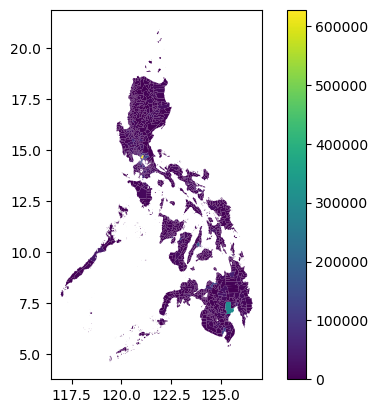

In [687]:
fig, ax = plt.subplots(1, 1)
gdf.plot(column='Water Sealed', ax=ax, legend=True)
